### Problem 1

$$
Y|\beta \sim \mathcal{N}(X\beta, \sigma_\epsilon^2 I_n)
$$
$$
\beta \sim \mathcal{N}(0, \sigma_\beta^2 I_p)
$$
Denote $a = \frac{1}{\sigma_\beta^2}$ and $b = \frac{1}{\sigma_\epsilon^2}$.

We have the exact posterior distribution:

$$
\beta | Y \sim \mathcal{N}(\mu, \Sigma)
$$
where 
$$
\mu = \left(\frac{a}{b} I + X^T X\right)^{-1} X^T Y, \quad \Sigma = \left(a + b X^T X\right)^{-1}
$$

$$
\log P(Y, \beta; a, b) = -\frac{1}{2} \left[
b \sum_{n=1}^N (y_n - \beta^T x_n)^2 - p\log \frac{a}{2\pi} +a \beta^T\beta - N \log \frac{b}{2\pi}
\right]
$$

$$
\log P(Y;a, b) = -\frac{1}{2} \left[
\log |\frac{1}{a}XX^T + \frac{1}{b}I_n| + Y^T (\frac{1}{a}XX^T + \frac{1}{b}I_n)^{-1} Y + p \log(2\pi)
\right]
$$

We can also approximate this posterior distribution by mean-field:
$$
q(\beta) = \sum_{j=1}^p q_j(\beta_j)
$$

$$
\log q(\beta_j) = \mathbb{E}_{i\neq j}[\log p(Y, \beta)] + \text{const}\\
=-\frac{1}{2}\left(b \sum_{i=1}^n X_{ij}^2 + a\right) \beta_j^2 + b \sum_{i=1}^n \left(Y_i X_{ij} - \sum_{k\neq j}X_{ik}\mathbb{E}[\beta_k]X_{i,j}\right) \beta_j + \text{const}
$$

This implies that $\beta_j \sim \mathcal{N}(\mu_j, \sigma^2_j)$, 
where 
$$
\mu_j = \frac{b \sum_{i=1}^n \left(Y_i X_{ij} - \sum_{k\neq j}X_{ik}\mu_kX_{i,j}\right)}{b \sum_{i=1}^n X_{ij}^2 + a}, \quad \sigma^2_j = \frac{1}{b\sum_{i=1}^n X_{ij}^2 + a}.
$$

Lower bound:
$$
L(q) = \int q(\beta) \log \frac{P(Y, \beta)}{q(\beta)} d \beta = -\frac{1}{2}\left[
b \sum_{n=1}^N \mathbb{E}_{q(\beta)}[(y_n-\beta^Tx_n)^2 - p \log \frac{a}{2\pi} + a\mathbb{E}_{q(\beta)}[\beta^T\beta] - N \log\frac{b}{2\pi}
\right] - \mathbb{E}_{q(\beta)}[\log q(\beta)] 
$$
$$
= -\frac{1}{2}\left[b \sum_{i=1}^n ((y_i - \mu^T x_i)^2 + Tr(x_nx_n^T Diag(\sigma_j))+ a \left(\mu^T\mu + \sum_{j=1}^p \sigma_j^2\right)- p \log \frac{a}{2\pi}- N \log\frac{b}{2\pi}\right]+ \frac{1}{2}\log((2\pi)^p\prod_j \sigma_j^2)
$$
$$
= -\frac{1}{2}\left[
b \left(\|y-X\mu\|^2+Tr(X^TX Diag(\sigma_j^2)\right)+ a \left(\mu^T\mu + Tr(\sigma_j^2)\right) - p \log \frac{a}{2\pi}- N \log\frac{b}{2\pi}\right]+ \frac{1}{2}\log((2\pi)^p\prod_j \sigma_j^2)
$$

Hence, we have similar updating rule as EM:
$$
a = \frac{p}{\mu^T\mu + Tr(\sigma^2)}
$$
$$
b = \frac{n}{\|y-X\mu\|^2+Tr(X^TX Diag(\sigma_j^2)}
$$

Next, we use simulation to verify that the posterior mean obtained by mean-field is accurate while the posterior variance is underestimated.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from numpy.random import default_rng
rng = default_rng()

In [2]:
# Generate data using my favorite statistical model
class DataGen:
    def __init__(self, n=1000, p=100, sigma_e=10, seed=1):
        rng = default_rng(seed)
        X = rng.standard_normal((n, p))
        beta = rng.standard_normal(p)/np.sqrt(p)
        e = rng.standard_normal(n)*sigma_e
        Y0 = X.dot(beta)
        Y = Y0 + e 
        self.X = X
        self.Y = Y
        self.beta = beta
        self.a_truth = p 
        self.b_truth = sigma_e**(-2)

In [3]:
class MF:
    def __init__(self, X, y, tol=1e-6):
        self.X = X
        self.y = y 
        self.n, self.p = self.X.shape
        self.tol = tol 
        
    def var(self, a, b):
        return 1.0/(a + b*(self.X**2).sum(axis=0))
    
    def mu(self, a, b):
        coef = b*self.var(a, b)
        tmp = self.y.dot(self.X)
        mu = np.random.random(self.p)
        while True:
            tmp2 = self.X.dot(mu).dot(self.X) - ((self.X**2)*mu).sum(axis=0)
            mu_update = coef*(tmp - tmp2)
            if np.linalg.norm(mu_update - mu, ord=1) < self.tol:
                break
            mu = mu_update
        return mu
    
    def elbo(self, a, b, mu, sigma):
        first_term = b * (np.linalg.norm(self.y - self.X@mu)**2 + np.trace(self.X.T@self.X@sigma))
        second_term = a * (mu.T@mu + np.trace(sigma))
        entropy_term = np.sum(np.log(np.diag(sigma)))
        return -0.5*(first_term + second_term - entropy_term - self.p*np.log(a/2/np.pi) - self.n*np.log(b/2/np.pi))
    
    
    def solver(self, a0, b0, tol=1e-6):
        X, y = self.X, self.y
        elbos = []
        elbos.append(self.elbo(a0, b0, self.mu(a0,b0), np.diag(self.var(a0, b0))))
        a, b = a0, b0
        while True:
            mu = self.mu(a, b)
            sigma = np.diag(self.var(a, b))
            a = self.p/(mu.T@mu + np.trace(sigma))
            b = self.n/(np.linalg.norm(y-X@mu)**2 + np.trace(X.T@X@sigma))
            elbos.append(self.elbo(a, b, mu, sigma))
            if np.abs((elbos[-1]-elbos[-2])/elbos[-2]) < tol:
                break
        return a, b, elbos

In [4]:
class EM:
    def __init__(self, X, y):
        self.X = X 
        self.y = y 
        self.n, self.p = self.X.shape 
        
    def mu_r(self, a, b):
        X = self.X
        y = self.y
        return np.linalg.inv(a/b*np.eye(self.p) + X.T@X)@X.T@y
    
    def sigma_r(self, a, b):
        return np.linalg.inv(a + b*self.X.T@self.X)
    
    def llh(self, a, b):
        X = self.X
        tmp = X@X.T/a + np.identity(self.n)/b
        sign, logdet = np.linalg.slogdet(tmp)
        t = logdet + self.y.T@np.linalg.inv(tmp)@self.y + self.n*np.log(2*np.pi)
        return -1/2*t
    
    def solver(self, a0, b0, tol=1e-6):
        X, y = self.X, self.y
        llhs = []
        llhs.append(self.llh(a0, b0))
        a, b = a0, b0 
        while True:
            mu = self.mu_r(a, b)
            sigma = self.sigma_r(a, b)
            a = self.p/(mu.T@mu + np.trace(sigma))
            b = self.n/(np.linalg.norm(y-X@mu)**2 + np.trace(X.T@X@sigma))
            llhs.append(self.llh(a, b))
            if np.abs((llhs[-1]-llhs[-2])/llhs[-2]) < tol:
                break
        return a, b, llhs

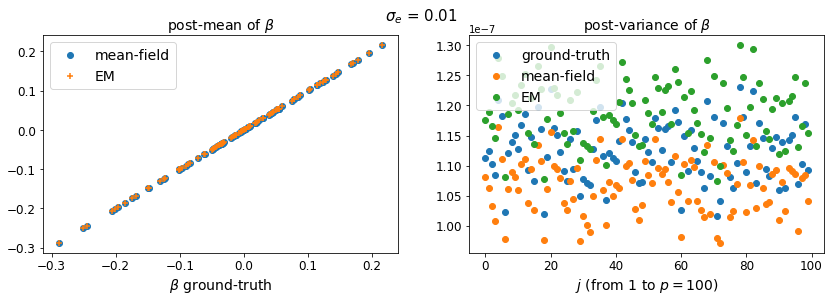

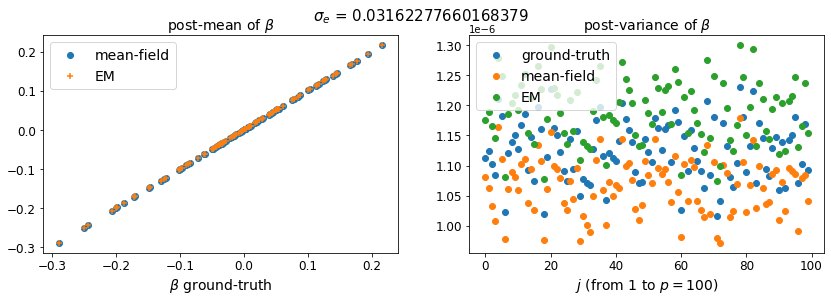

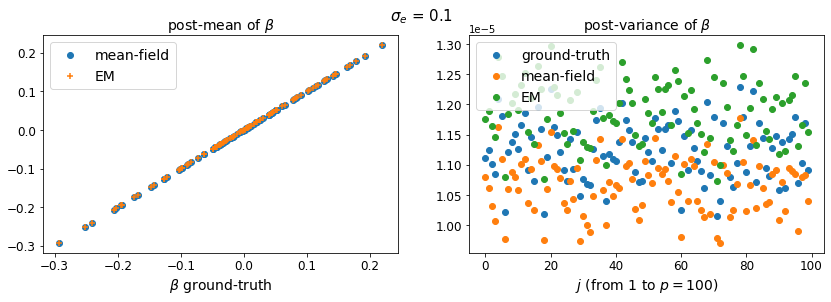

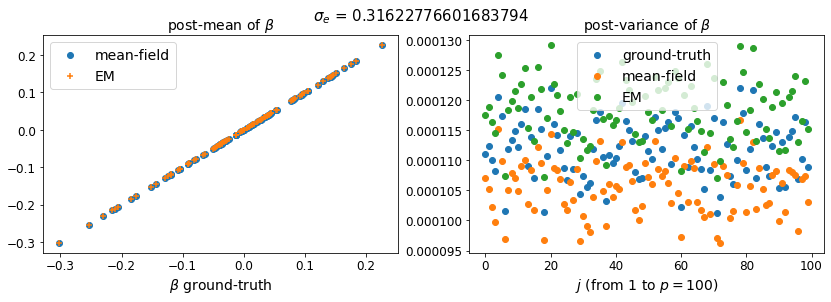

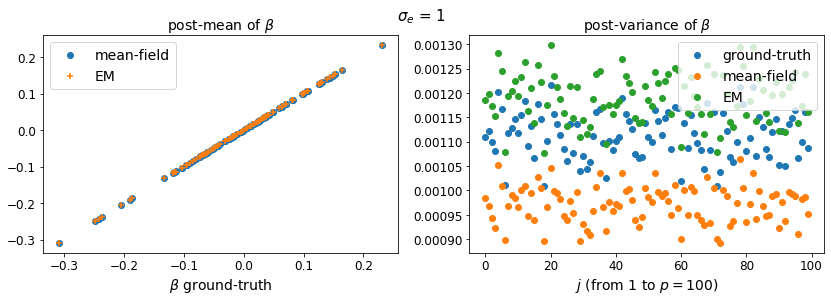

In [5]:
sigma_e_list = [10**(-2), 10**(-1.5), 10**(-1), 10**(-0.5), 1] 
# b = 10^4, 10^3, 10^2, 10, 1

for sigma_e in sigma_e_list:
    data = DataGen(1000, 100, sigma_e=sigma_e) # a = p = 100

    mf_model = MF(data.X, data.Y)
    em_model = EM(data.X, data.Y)

    beta_truth = em_model.mu_r(data.a_truth, data.b_truth)
    var_truth = np.diagonal(em_model.sigma_r(data.a_truth, data.b_truth))
    
    a, b, _ = mf_model.solver(1, 1)
    beta_mf = mf_model.mu(a, b)
    var_mf = mf_model.var(a, b)
    
    a, b, _ = em_model.solver(1, 1)
    beta_em = em_model.mu_r(a, b)
    var_em = np.diagonal(em_model.sigma_r(a, b))

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].scatter(beta_truth, beta_mf, marker='o', label='mean-field')
    ax[0].scatter(beta_truth, beta_em, marker='+', label='EM')
    ax[0].set_xlabel('$\\beta$ ground-truth', fontsize=14) 
    ax[0].set_title('post-mean of $\\beta$', fontsize=14)
    ax[0].tick_params(labelsize=12)
    ax[0].legend(fontsize=14)
    ax[1].scatter(np.arange(data.X.shape[1]), var_truth, label='ground-truth')
    ax[1].scatter(np.arange(data.X.shape[1]), var_mf, label='mean-field')
    ax[1].scatter(np.arange(data.X.shape[1]),var_em, label='EM')
    ax[1].set_title('post-variance of $\\beta$', fontsize=14)
    ax[1].set_xlabel('$j$ (from $1$ to $p=100$)', fontsize=14) 
    ax[1].tick_params(labelsize=12)
    ax[1].legend(fontsize=14)
    plt.suptitle(f'$\\sigma_e$ = {sigma_e}', fontsize=15)
    plt.show()

#### Discussion

In my simulation, I verified that the posterior mean is accurate while the posterior variance is underestimated. I also find that the noise $\sigma_e$ affect the quality of posterior variance estiamtion of mean-field. The stronger noise $\sigma_e$ is, the more underestimation is. Meanwhile, the posterior mean estimation is always accurate enough.

Another intersting finding in my simulation is that, EM in **finite** steps overestimates the posterior variance. Although EM estimates the groung truth parameters consistently, in finite iteration steps, there is still numerical error, thus causing the error of posterior variance estimation. It is still questioning whether this "finite-step over-estimation" phenomenon holds generally.